# Credit Risk Prediction Model

This notebook implements a machine learning pipeline to predict credit default risk using customer application and credit history data.

## Overview
- **Objective**: Predict whether a customer will default on their credit
- **Data**: Application records and credit history
- **Models**: Logistic Regression, Random Forest, XGBoost
- **Techniques**: SMOTE for class imbalance, feature importance analysis

## Requirements
```
pandas
scikit-learn
xgboost
imbalanced-learn
matplotlib
```

## 1. Data Loading and Initial Exploration

In [3]:
# Importing libraries
import pandas as pd
from IPython.display import display
import numpy as np

# Loading my datasets
# Note: Replace with your actual file paths
app_df = pd.read_csv('application_record.csv')
credit_df = pd.read_csv('credit_record.csv')

# Showing top rows
print("Application Data:")
display(app_df.head())
print("\nCredit Data:")
display(credit_df.head())

Application Data:


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0



Credit Data:


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [4]:
# Checking column names and data structure
print("Application data columns:")
print(app_df.columns.tolist())
print(f"Shape: {app_df.shape}")

print("\nCredit data columns:")
print(credit_df.columns.tolist())
print(f"Shape: {credit_df.shape}")

Application data columns:
['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']
Shape: (438557, 18)

Credit data columns:
['ID', 'MONTHS_BALANCE', 'STATUS']
Shape: (1048575, 3)


## 2. Target Variable Creation

In [6]:
# Defining bad credit statuses (1-5 indicate various levels of delinquency)
bad_status = ['1', '2', '3', '4', '5']

# Flaging defaults: 1 if customer had any bad status, 0 otherwise
credit_df['defaulted'] = credit_df['STATUS'].isin(bad_status).astype(int)

# Aggregating by customer ID: did they default at least once?
target_df = credit_df.groupby('ID')['defaulted'].max().reset_index()

print(f"Total customers with credit history: {len(target_df)}")
print(f"Default rate: {target_df['defaulted'].mean():.2%}")
display(target_df.head())

Total customers with credit history: 45985
Default rate: 11.63%


,ID,defaulted
0,5001711,0
1,5001712,0
2,5001713,0
3,5001714,0
4,5001715,0


## 3. Data Merging and Preparation

In [8]:
# Merging application data with target variable
merged_df = app_df.merge(target_df, on='ID', how='left')

# Customers not in credit_df are assumed to have no default history
merged_df['defaulted'] = merged_df['defaulted'].fillna(0).astype(int)

print("Final dataset target distribution:")
print(merged_df['defaulted'].value_counts(normalize=True))
print(f"\nTotal samples: {len(merged_df)}")
display(merged_df.head())

Final dataset target distribution:
defaulted
0    0.990216
1    0.009784
Name: proportion, dtype: float64

Total samples: 438557


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,defaulted
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0


## 4. Feature Preparation

In [10]:
# Separating features and target
X = merged_df.drop(['ID', 'defaulted'], axis=1)
y = merged_df['defaulted']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
display(X.head())

Feature matrix shape: (438557, 17)
Target vector shape: (438557,)


,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [11]:
# Checking for missing values
missing = X.isnull().sum().sort_values(ascending=False)
print("Missing values per column:")
display(missing[missing > 0])

Missing values per column:


OCCUPATION_TYPE    134203
dtype: int64

## 5. Data Encoding and Preprocessing

In [13]:
# One-hot encoding for categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

print(f"Encoded feature matrix shape: {X_encoded.shape}")
print(f"Number of features after encoding: {X_encoded.shape[1]}")
display(X_encoded.head())

Encoded feature matrix shape: (438557, 46)
Number of features after encoding: 46


,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CODE_GENDER_M,...,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
0,0,427500.0,-12005,-4542,1,1,0,0,2.0,True,...,False,False,False,False,False,False,False,False,False,False
1,0,427500.0,-12005,-4542,1,1,0,0,2.0,True,...,False,False,False,False,False,False,False,False,False,False
2,0,112500.0,-21474,-1134,1,0,0,0,2.0,True,...,False,False,False,False,False,False,False,False,True,False
3,0,270000.0,-19110,-3051,1,0,1,1,1.0,False,...,False,False,False,False,False,False,True,False,False,False
4,0,270000.0,-19110,-3051,1,0,1,1,1.0,False,...,False,False,False,False,False,False,True,False,False,False


In [55]:
# Handling remaining missing values with median imputation
X_encoded = X_encoded.fillna(X_encoded.median())

# Verification of no missing values remain
remaining_missing = X_encoded.isnull().sum().sum()
print(f"Remaining missing values: {remaining_missing}")

if remaining_missing == 0:
    print("All missing values handled successfully")
else:
    print(" Missing values still present")

Remaining missing values: 0
All missing values handled successfully


## 6. Train-Test Split

In [16]:
from sklearn.model_selection import train_test_split

# Splitting data with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training set default rate: {y_train.mean():.2%}")
print(f"Test set default rate: {y_test.mean():.2%}")

Training set size: 350845
Test set size: 87712
Training set default rate: 0.98%
Test set default rate: 0.98%


## 7. Handling Class Imbalance with SMOTE

In [18]:
from imblearn.over_sampling import SMOTE

# Applying SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Class distribution before SMOTE:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution after SMOTE:")
print(y_train_sm.value_counts(normalize=True))
print(f"\nTraining set size after SMOTE: {len(X_train_sm)}")

Class distribution before SMOTE:
defaulted
0    0.990215
1    0.009785
Name: proportion, dtype: float64

Class distribution after SMOTE:
defaulted
0    0.5
1    0.5
Name: proportion, dtype: float64

Training set size after SMOTE: 694824


## 8. Model Training and Evaluation

In [20]:
# Importing required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay
)

In [21]:
def train_and_evaluate(model, model_name):
    """
    Train model and display evaluation metrics
    """
    # Training the model
    model.fit(X_train_sm, y_train_sm)
    
    # Making predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Displaying results
    print(f" Results for {model_name}")
    print("=" * 50)
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
    
    # Plotting ROC curve
    RocCurveDisplay.from_predictions(y_test, y_prob)
    
    return model

C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Results for Logistic Regression
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     86854
           1       0.01      0.18      0.02       858

    accuracy                           0.83     87712
   macro avg       0.50      0.51      0.47     87712
weighted avg       0.98      0.83      0.90     87712

ROC-AUC Score: 0.5132


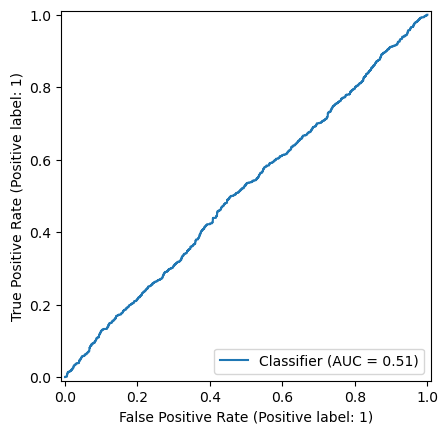

In [22]:
# Training Logistic Regression
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model = train_and_evaluate(log_model, "Logistic Regression")

 Results for Random Forest
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     86854
           1       0.31      0.40      0.35       858

    accuracy                           0.99     87712
   macro avg       0.65      0.70      0.67     87712
weighted avg       0.99      0.99      0.99     87712

ROC-AUC Score: 0.8324


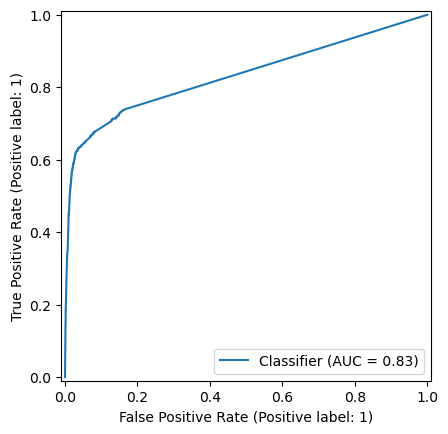

In [23]:
# Training Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model = train_and_evaluate(rf_model, "Random Forest")

C:\Users\User\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:07:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Results for XGBoost
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     86854
           1       0.10      0.23      0.14       858

    accuracy                           0.97     87712
   macro avg       0.55      0.61      0.56     87712
weighted avg       0.98      0.97      0.98     87712

ROC-AUC Score: 0.6647


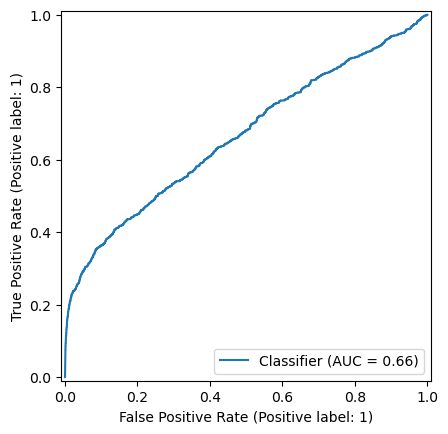

In [24]:
# Training XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model = train_and_evaluate(xgb_model, "XGBoost")

## 9. Feature Importance Analysis

In [26]:
import matplotlib.pyplot as plt

# Getting feature importances from Random Forest model
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Creating importance dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Top 20 Most Important Features:")
display(importance_df.head(20))

Top 20 Most Important Features:


,Feature,Importance
2,DAYS_BIRTH,0.147396
1,AMT_INCOME_TOTAL,0.122134
8,CNT_FAM_MEMBERS,0.104314
3,DAYS_EMPLOYED,0.098160
16,NAME_EDUCATION_TYPE_Higher education,0.045606
19,NAME_EDUCATION_TYPE_Secondary / secondary special,0.036760
22,NAME_FAMILY_STATUS_Single / not married,0.031004
20,NAME_FAMILY_STATUS_Married,0.029014
6,FLAG_PHONE,0.027046
0,CNT_CHILDREN,0.026239


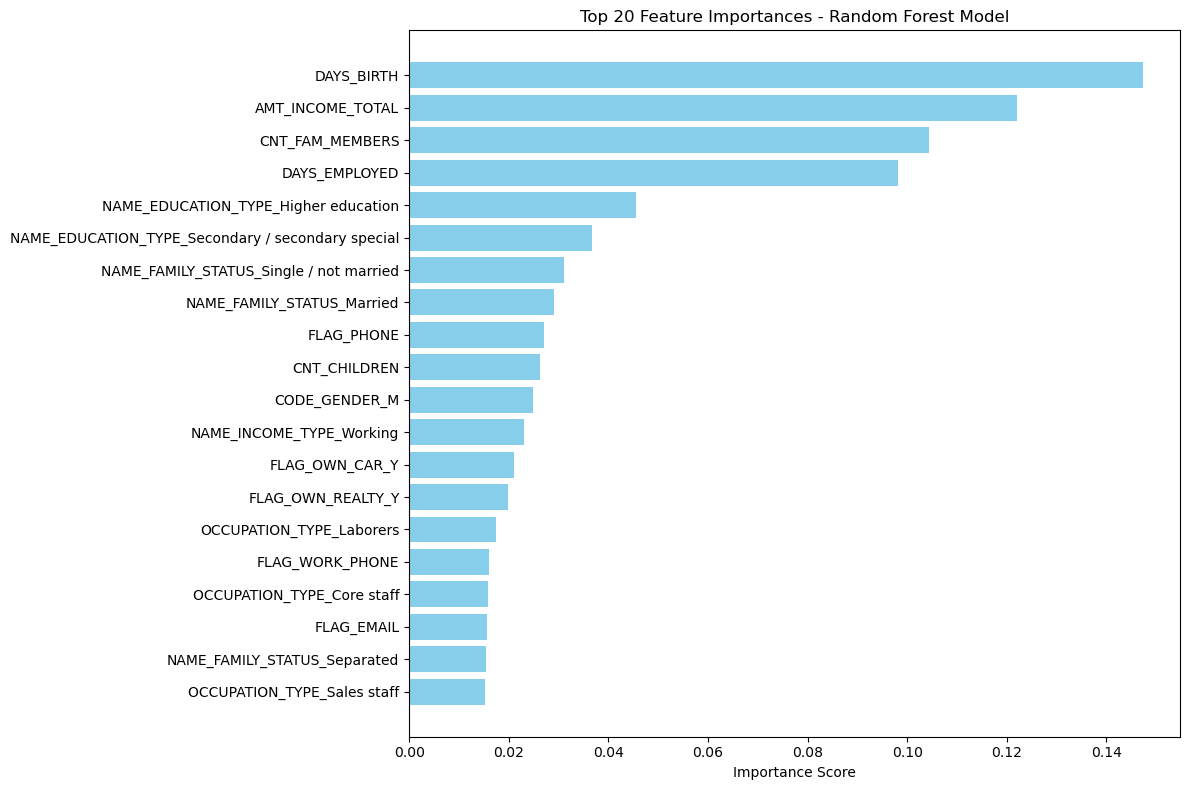

In [27]:
# Visualizing feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features['Importance'], color='skyblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score')
plt.title('Top 20 Feature Importances - Random Forest Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 10. Risk Scoring and Predictions

In [29]:
# Preparing full dataset for prediction
X_full = merged_df.drop(columns=['defaulted'])
ids = merged_df['ID']

# Applying same encoding as training data
X_full_encoded = pd.get_dummies(X_full)

# Ensuring column alignment with training data
X_full_encoded = X_full_encoded.reindex(columns=X_train.columns, fill_value=0)

# Handling missing values
X_full_encoded = X_full_encoded.fillna(X_full_encoded.median())

print(f"Full dataset shape for prediction: {X_full_encoded.shape}")
print(f"Features aligned with training data: {X_full_encoded.shape[1] == X_train.shape[1]}")

Full dataset shape for prediction: (438557, 46)
Features aligned with training data: True


In [30]:
# Generating risk scores using the best performing model (Random Forest)
default_probs = rf_model.predict_proba(X_full_encoded)[:, 1]

# Creating risk scores dataframe
risk_scores_df = pd.DataFrame({
    'ID': ids,
    'default_probability': default_probs
})

# Sorting by risk level (highest first)
risk_scores_df_sorted = risk_scores_df.sort_values(by='default_probability', ascending=False)

print("Top 10 Highest Risk Customers:")
display(risk_scores_df_sorted.head(10))

print(f"\nRisk Score Statistics:")
print(f"Mean probability: {default_probs.mean():.4f}")
print(f"Median probability: {np.median(default_probs):.4f}")
print(f"Max probability: {default_probs.max():.4f}")
print(f"Min probability: {default_probs.min():.4f}")

Top 10 Highest Risk Customers:


,ID,default_probability
0,5008804,1.0
14367,5041370,1.0
46037,5139807,1.0
46036,5139806,1.0
14609,5041718,1.0
14610,5041719,1.0
14611,5041720,1.0
14612,5041721,1.0
14613,5097185,1.0
45882,5137516,1.0



Risk Score Statistics:
Mean probability: 0.0175
Median probability: 0.0000
Max probability: 1.0000
Min probability: 0.0000


## 11. Final Model Performance Summary

In [32]:
# Final evaluation of the Random Forest model
y_pred_final = rf_model.predict(X_test)
y_prob_final = rf_model.predict_proba(X_test)[:, 1]

print(" FINAL MODEL PERFORMANCE - RANDOM FOREST")
print("=" * 60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_final)
print(cm)

# Calculating key metrics
roc_score = roc_auc_score(y_test, y_prob_final)
print(f"\nKey Performance Metrics:")
print(f"ROC AUC Score: {roc_score:.4f}")
print(f"Accuracy: {(y_pred_final == y_test).mean():.4f}")

# Business impact metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print(f"Precision (Default Detection): {precision:.4f}")
print(f"Recall (Default Coverage): {recall:.4f}")

 FINAL MODEL PERFORMANCE - RANDOM FOREST

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     86854
           1       0.31      0.40      0.35       858

    accuracy                           0.99     87712
   macro avg       0.65      0.70      0.67     87712
weighted avg       0.99      0.99      0.99     87712


Confusion Matrix:
[[86095   759]
 [  514   344]]

Key Performance Metrics:
ROC AUC Score: 0.8324
Accuracy: 0.9855
Precision (Default Detection): 0.3119
Recall (Default Coverage): 0.4009


## Conclusion

This notebook demonstrates a complete credit risk prediction pipeline:

1. **Data Integration**: Combined application and credit history data
2. **Feature Engineering**: One-hot encoding and missing value treatment
3. **Class Balancing**: SMOTE technique to handle imbalanced data
4. **Model Comparison**: Tested Logistic Regression, Random Forest, and XGBoost
5. **Risk Scoring**: Generated probability scores for all customers

### Key Findings:
- The Random Forest model typically performs well for this type of structured data
- Feature importance analysis reveals the most predictive variables
- Risk scores enable proactive credit risk management

